In [ ]:
!pip install torch torchvision -q

In [1]:
import os
from PIL import Image
import gc

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score


import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

### Number of parameters in models

In [6]:
from transformer.vit import Transformer

NUM_CLASS=4


resnet_34 = torchvision.models.resnet34(pretrained=False, num_classes=NUM_CLASS)
# ---
resnet_modified = torchvision.models.resnet34(pretrained=False, num_classes=NUM_CLASS)

resnet_modified.conv1 = torch.nn.Conv2d(3, 64, 
                                        kernel_size=(3, 3), 
                                        stride=(1, 1), 
                                        padding=(1, 1), 
                                        bias=False)

resnet_modified.maxpool = torch.nn.Identity()
# ---

effnet = torchvision.models.efficientnet_b0(pretrained=False, num_classes=NUM_CLASS)

# ---

transformer = Transformer(img_size=(240, 320),
                          patch_size=(8, 8),
                          in_channels=3,
                          n_classes=NUM_CLASS,
                          embed_dim=128,
                          depth=6,
                          n_heads=16,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          p=0.3,
                          attn_p=0.3
                         )

In [7]:
models = [resnet_34, resnet_modified, effnet, transformer]
names = ['resnet_34', 'resnet_modified', 'effnet', 'transformer']

In [8]:
params = []


for name, model in zip(names, models):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    params.append([name, pytorch_total_params//1000, pytorch_train_params//1000])


params = pd.DataFrame(params, columns=['model', 'total parameters, ths.', 'trainable parameters, ths.'])
params.to_csv('multi_class_output/params.csv', index=False)
params

,model,"total parameters, ths.","trainable parameters, ths."
0,resnet_34,21286,21286
1,resnet_modified,21279,21279
2,effnet,4012,4012
3,transformer,1368,1368


### Multi-class probplem

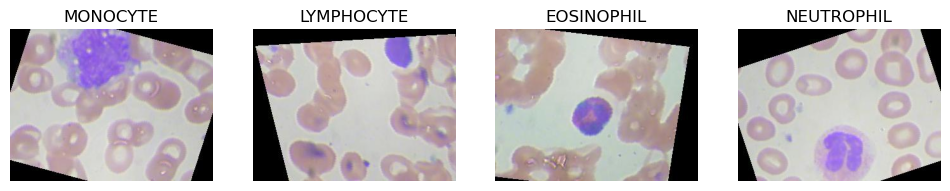

In [9]:
show_sample = []
for label in os.listdir('dataset2-master/dataset2-master/images/TRAIN/'):
    img_id = os.listdir('dataset2-master/dataset2-master/images/TRAIN/' + label)

    show_sample.append(('dataset2-master/dataset2-master/images/TRAIN/' + label + '/' + img_id[0], label))

fig, axis = plt.subplots(1, 4, figsize=(12, 3))

for sample, ax in zip(show_sample, axis.flatten()):

    img_path, label = sample
    img = plt.imread(img_path)

    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

In [10]:
path_train = './dataset2-master/dataset2-master/images/TRAIN/'
train = pd.DataFrame(columns=['img_id', 'label'])

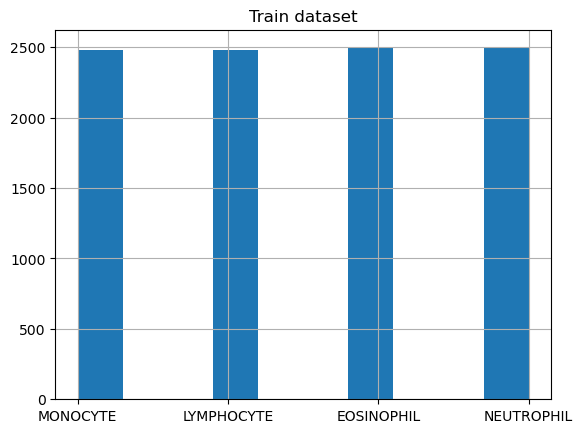

In [11]:
for label in os.listdir(path_train):
    
    img_id = os.listdir('dataset2-master/dataset2-master/images/TRAIN/' + label)
    df = pd.DataFrame(img_id, columns=['img_id'])
    df['label'] = label
    train = pd.concat([train, df])
        
        
clean_mask = train['img_id'].apply(lambda x: x.split('/')[-1] =='.ipynb_checkpoints')
train = train.loc[~clean_mask, :].reset_index(drop=True)

train.label.hist()
plt.title('Train dataset')
plt.show()

In [12]:
path_test = './dataset2-master/dataset2-master/images/TEST/'
test = pd.DataFrame(columns=['img_id', 'label'])

for label in os.listdir(path_test):
    mg_id = os.listdir('dataset2-master/dataset2-master/images/TEST/' + label)
    df = pd.DataFrame(img_id, columns=['img_id'])
    df['label'] = label
    test = pd.concat([test, df])
    
clean_mask = test['img_id'].apply(lambda x: x.split('/')[-1] =='.ipynb_checkpoints')
test = test.loc[~clean_mask, :].reset_index(drop=True)

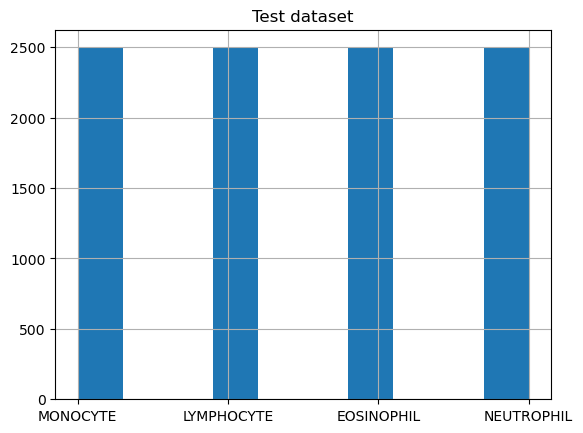

In [13]:
test.label.hist()
plt.title('Test dataset')
plt.show()


### Metrics

In [146]:
path='multi_class_output/multi_class_output_0/'

In [147]:
metrics = [met for met in os.listdir(path) if met[-11:]=='metrics.csv']

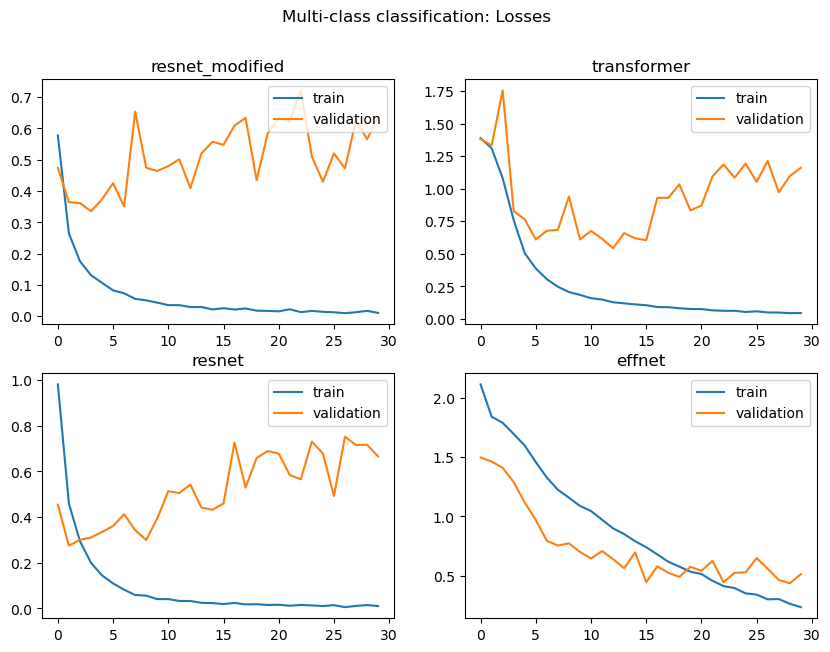

In [148]:
fig, axis = plt.subplots(2, 2, figsize=(10, 7))

for metric_file_name, ax in zip(metrics, axis.flatten()):
    
    path_metric = os.path.join(path, metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    ax.plot(np.arange(len(train_loss)), train_loss, label='train')
    ax.plot(np.arange(len(val_loss)), val_loss, label='validation')
    ax.legend(loc="upper right")
    ax.set_title(metric_file_name[:-12])
    
plt.suptitle('Multi-class classification: Losses')
plt.savefig('multi_class_output/classlosses.png')
plt.show()

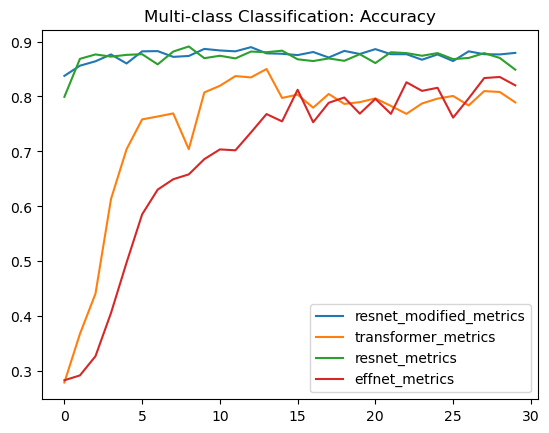

In [149]:
for metric_file_name in metrics:
    
    path_metric = os.path.join(path, metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    plt.legend()
    plt.title('Multi-class Classification: Accuracy')
    
plt.savefig('multi_class_output/classacc.png')
plt.show()

In [6]:
def eval_metrics(list_metrics, names, path='', multi_label=False):
    
    models_metrics=[]
    
    for name, metric in zip(names, list_metrics):
        
        if not multi_label:
            
            preds = pd.read_csv(path + metric, names=['t', 'p'], skiprows=1)
            preds = (preds['t'].values, preds['p'].values)

            accuracy = sklearn.metrics.accuracy_score(*preds)
            precis_macro = sklearn.metrics.precision_score(*preds, average='macro')
            precis_micro = sklearn.metrics.precision_score(*preds, average='micro')

            recall_macro = sklearn.metrics.recall_score(*preds, average='macro')
            recall_micro = sklearn.metrics.recall_score(*preds, average='micro')

            f1_macro = sklearn.metrics.f1_score(*preds, average='macro')
            f1_micro = sklearn.metrics.f1_score(*preds, average='micro')

            models_metrics.append([name, accuracy, 
                                   precis_macro, precis_micro, 
                                   recall_macro, recall_micro,
                                   f1_macro, f1_micro])
            columns=['model', 'accuracy', 'precision (macro)', 'precision (micro)', 
                     'recall (macro)', 'recall (micro)', 'F1 (macro)', 'F1 (micro)']
            
            
        else:
            preds = metric
            ex_r = sklearn.metrics.accuracy_score(*preds, normalize=True, sample_weight=None)
            hamm = sklearn.metrics.accuracy_score(*preds, normalize=True, sample_weight=None)
            Recall = sklearn.metrics.precision_score(*preds, average='samples') 
            Precision = sklearn.metrics.recall_score(*preds, average='samples')
            f1 = sklearn.metrics.f1_score(*preds, average='samples')
            models_metrics.append([name, ex_r, hamm, Recall, Precision, f1])
            
            columns=['model', 'Exact Match Ratio', 'Hamming loss', 'Recall', 'Precision', 'F1']


            

    models_metrics = pd.DataFrame(models_metrics, columns=columns)
    
    # if not multi_label:
    #     models_metrics.to_csv(path+'eval_result_class.csv', index=False)
    # else:
    #      models_metrics.to_csv(path+'eval_result_label.csv', index=False)

    return models_metrics.iloc[:, 1:].values

In [7]:
models_name = ['resnet', 'resnet_modified', 'effnet', 'transformer']

In [11]:
seed_names = ['multi_class_output_256272',
 'multi_class_output_0','multi_class_output_583','multi_class_output_vis',
 'multi_class_output_875468',
 'multi_class_output_42']

In [19]:
seed_results = np.zeros((1, 4, 7))
for seed in seed_names:

    metrics = [met for met in os.listdir(f'multi_class_output/{seed}/') if met[-9:]=='preds.csv']

    one_seed_results = eval_metrics(sorted(metrics), sorted(models_name), path=f'multi_class_output/{seed}/')
    one_seed_results = one_seed_results[None, :, :]
    seed_results = np.concatenate([seed_results, one_seed_results], axis=0)

In [20]:
columns=['accuracy', 'precision (macro)', 'precision (micro)', 
         'recall (macro)', 'recall (micro)', 'F1 (macro)', 'F1 (micro)']

models_metrics = pd.DataFrame(seed_results[1:, :, :].mean(axis=0), columns=columns)
models_metrics['model'] = sorted(models_name)
models_metrics = models_metrics[['model'] + columns]
models_metrics.to_csv('multi_class_output/eval_result_class.csv', index=False)

In [21]:
std_models_metrics = pd.DataFrame(seed_results[1:, :, :].std(axis=0), columns=columns)
std_models_metrics['model'] = sorted(models_name)
std_models_metrics = std_models_metrics[['model']+columns]

std_models_metrics.to_csv('multi_class_output/std_models_metrics.csv', index=False)

In [22]:
pd.read_csv('multi_class_output/eval_result_class.csv')

,model,accuracy,precision (macro),precision (micro),recall (macro),recall (micro),F1 (macro),F1 (micro)
0,effnet,0.851695,0.859673,0.851695,0.851806,0.851695,0.853528,0.851695
1,resnet,0.893245,0.916841,0.893245,0.893192,0.893245,0.895859,0.893245
2,resnet_modified,0.889626,0.910624,0.889626,0.889633,0.889626,0.892238,0.889626
3,transformer,0.862083,0.875718,0.862083,0.862152,0.862083,0.862672,0.862083


In [23]:
pd.read_csv('multi_class_output/std_models_metrics.csv')

,model,accuracy,precision (macro),precision (micro),recall (macro),recall (micro),F1 (macro),F1 (micro)
0,effnet,0.013591,0.010965,0.013591,0.013610,0.013591,0.012537,0.013591
1,resnet,0.002860,0.005251,0.002860,0.002870,0.002860,0.002798,0.002860
2,resnet_modified,0.014206,0.007133,0.014206,0.014265,0.014206,0.013286,0.014206
3,transformer,0.014636,0.011142,0.014636,0.014736,0.014636,0.013241,0.014636


### Multi-label problem

In [88]:
data = pd.read_csv('sample_labels.csv')
data['lables'] = data['Finding Labels'].str.split('|')

labels            
No Finding            3044
Infiltration           967
Effusion               644
Atelectasis            508
Nodule                 313
Mass                   284
Pneumothorax           271
Consolidation          226
Pleural_Thickening     176
Cardiomegaly           141
Emphysema              127
Edema                  118
Fibrosis                84
Pneumonia               62
Hernia                  13
dtype: int64

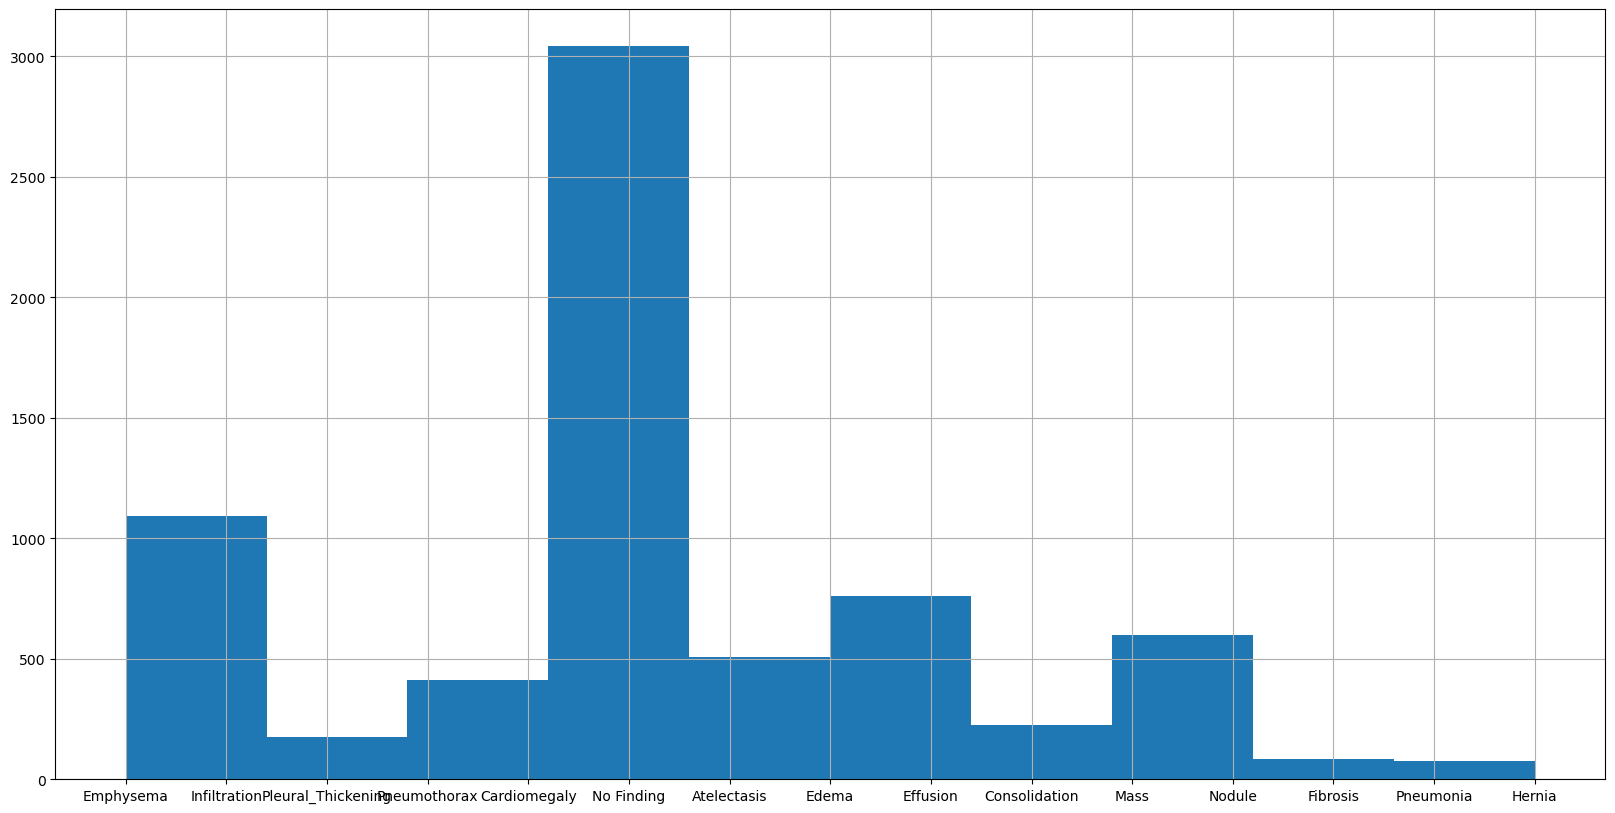

In [91]:
labels = []
for lable in data['lables'].values:
    labels.extend(lable)   
    
labels = pd.DataFrame(labels, columns=['labels'])

labels['labels'].hist(figsize=(20, 10))
labels.value_counts()

### Train/Test split

In [92]:
train = data.loc[:int(0.8*data.shape[0]), :]
test = data.loc[int(0.8*data.shape[0])+1:, :].reset_index(drop=True)

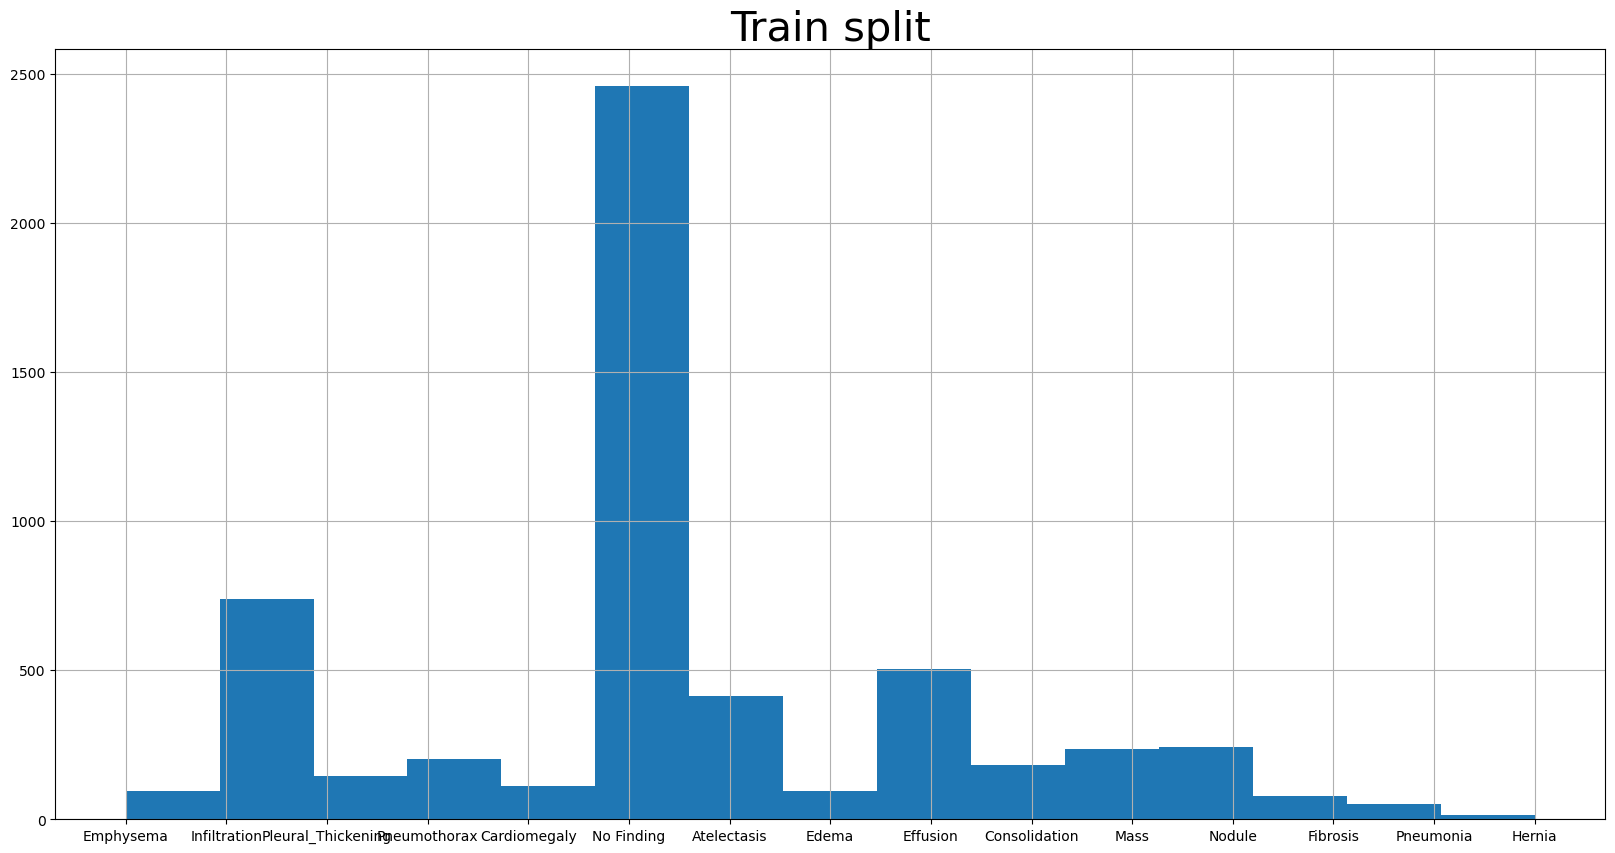

In [104]:
labels = []
for lable in train['lables'].values:
    labels.extend(lable)   
    
labels = pd.DataFrame(labels, columns=['labels'])

labels['labels'].hist(figsize=(20, 10), bins=15)
plt.title('Train split', fontsize=30)
plt.show()

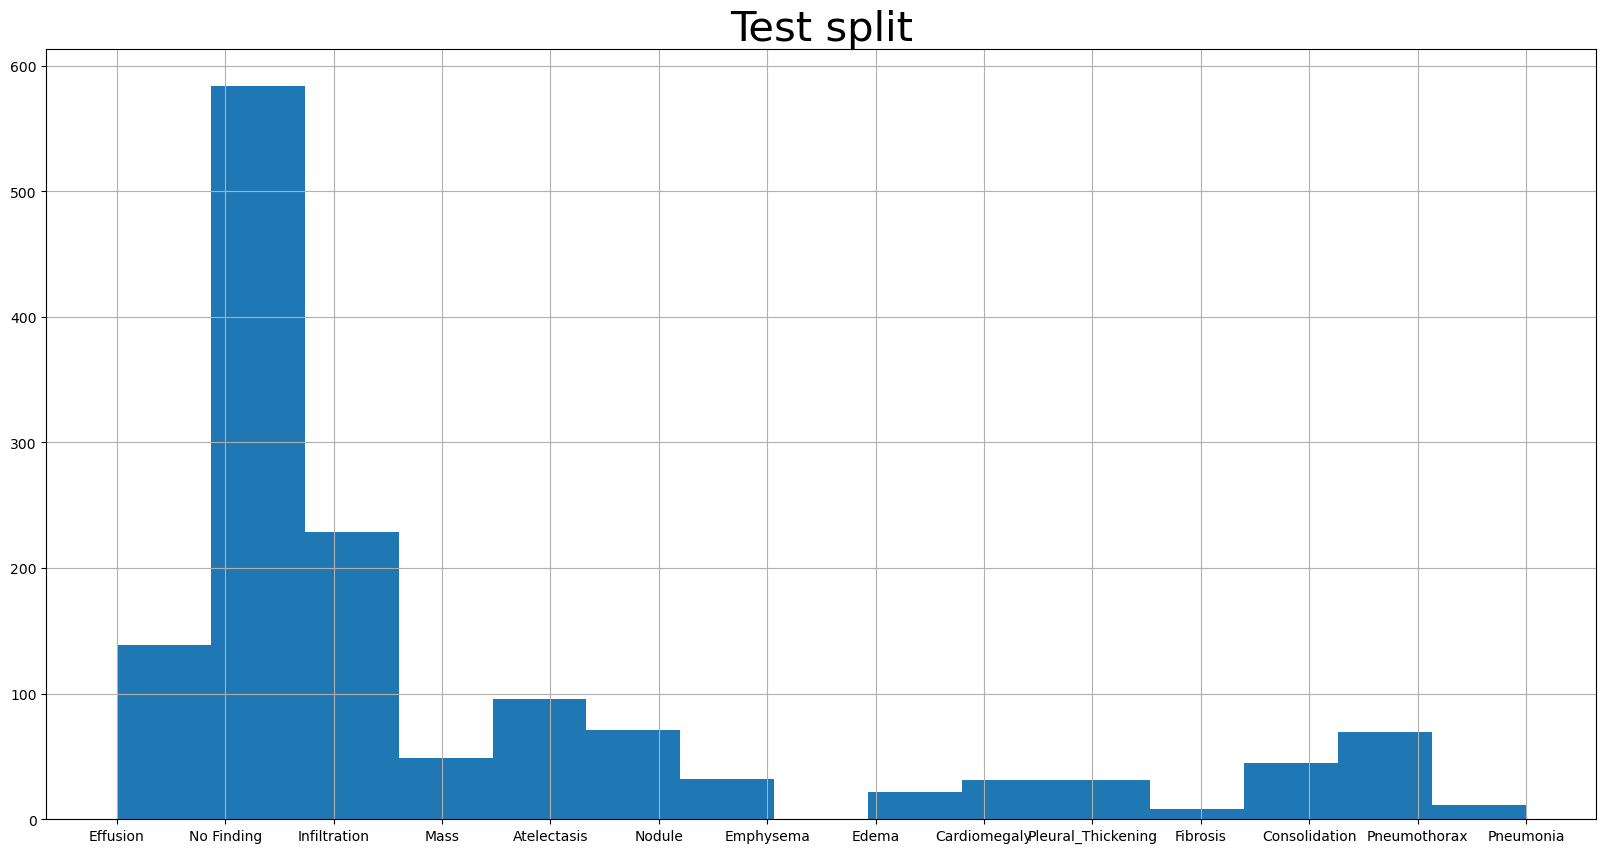

In [105]:
testlabels = []
for lable in test['lables'].values:
    testlabels.extend(lable)   
    
testlabels = pd.DataFrame(testlabels, columns=['labels'])

testlabels['labels'].hist(figsize=(20, 10), bins=15)
plt.title('Test split', fontsize=30)
plt.show()

### BCEloss

In [18]:
metrics = [met for met in os.listdir('multi_label_output/base') if met[-11:]=='metrics.csv']

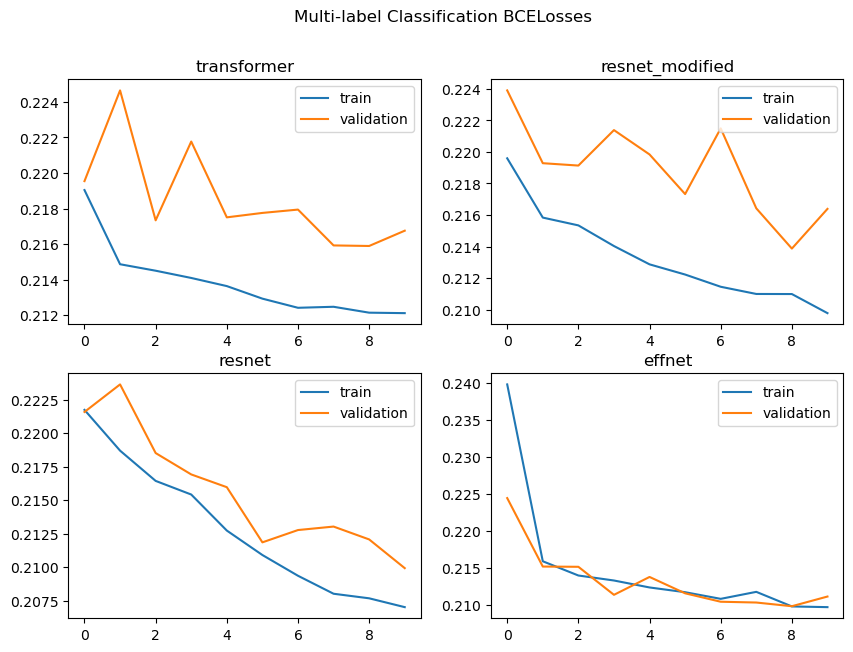

In [6]:
fig, axis = plt.subplots(2, 2, figsize=(10, 7))

for metric_file_name, ax in zip(metrics, axis.flatten()):
    
    path_metric = os.path.join('multi_label_output/base', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    ax.plot(np.arange(len(train_loss)), train_loss, label='train')
    ax.plot(np.arange(len(val_loss)), val_loss, label='validation')
    ax.legend(loc="upper right")
    ax.set_title(metric_file_name[:-12])
    
plt.suptitle('Multi-label Classification BCELosses')
plt.savefig('classbce.png')

plt.show()

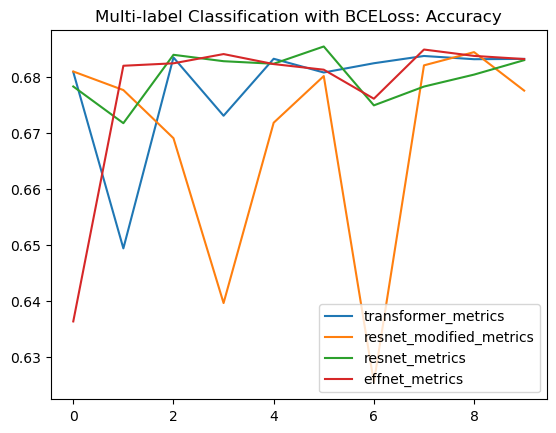

In [28]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_label_output/base', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    plt.legend(loc='lower right')
    plt.title('Multi-label Classification with BCELoss: Accuracy')
    
plt.savefig('labbceacc.png')


In [85]:
TRESHOLD=0.3


pred_metrics = [met for met in os.listdir('multi_label_output/base') if met[:4]=='pred']
true_metrics = [met for met in os.listdir('multi_label_output/base') if met[:4]=='true']


metrics = []
models_name = [item.split('.')[0][5:] for item in sorted(true_metrics)]

for true, pred in zip(sorted(true_metrics), sorted(pred_metrics)):
    true = pd.read_csv('multi_label_output/base/'+ true).astype(int).values
    pred = pd.read_csv('multi_label_output/base/'+ pred)
    pred = (pred > TRESHOLD).astype(int).values
    
    metrics.append((true, pred))

In [88]:
eval_metrics(metrics, models_name, multi_label=True)

,model,Exact Match Ratio,Hamming loss,Recall,Precision,F1
0,effnet,0.507583,0.507583,0.521855,0.519923,0.519090
1,resnet,0.444246,0.444246,0.515611,0.563069,0.530585
2,resnet_modified,0.446922,0.446922,0.497324,0.541406,0.511864
3,transformer,0.470116,0.470116,0.510705,0.541555,0.520755


### Focal

In [91]:
metrics = [met for met in os.listdir('multi_label_output/focal') if met[-11:]=='metrics.csv']

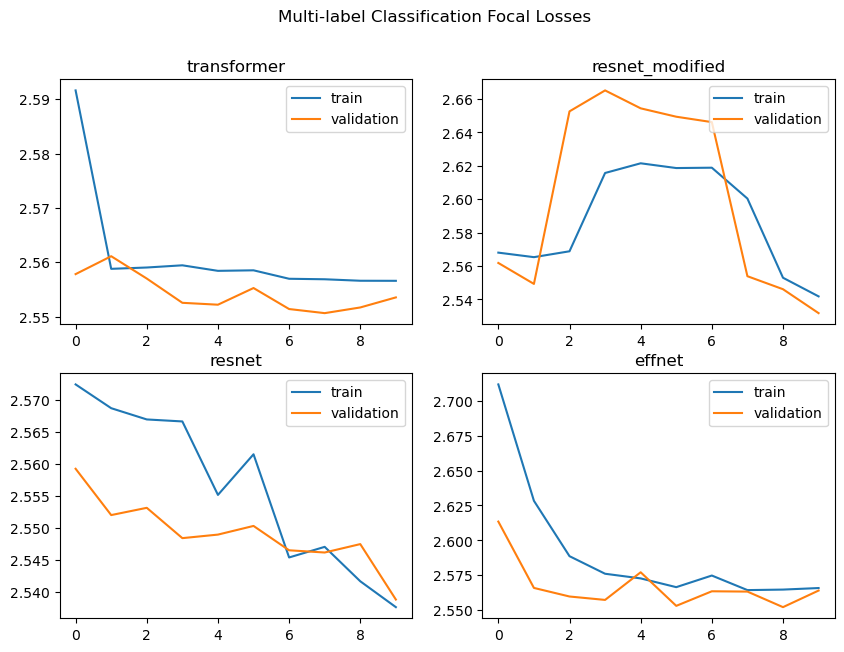

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(10, 7))

for metric_file_name, ax in zip(metrics, axis.flatten()):
    
    path_metric = os.path.join('multi_label_output/focal', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    ax.plot(np.arange(len(train_loss)), train_loss, label='train')
    ax.plot(np.arange(len(val_loss)), val_loss, label='validation')
    ax.legend(loc="upper right")
    ax.set_title(metric_file_name[:-12])
    
plt.suptitle('Multi-label Classification Focal Losses')
plt.savefig('classfocal.png')

plt.show()

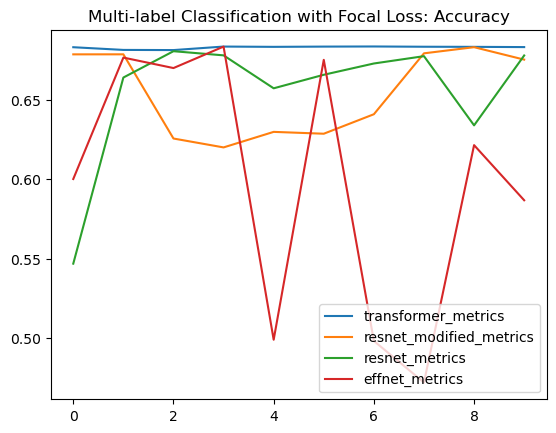

In [96]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_label_output/focal', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    plt.legend(loc='lower right')
    plt.title('Multi-label Classification with Focal Loss: Accuracy')
    
plt.savefig('labfocalacc.png')

In [127]:
TRESHOLD=0.3


pred_metrics = [met for met in os.listdir('multi_label_output/focal') if met[:4]=='pred']
true_metrics = [met for met in os.listdir('multi_label_output/focal') if met[:4]=='true']


metrics = []
models_name = [item.split('.')[0][5:] for item in sorted(true_metrics)]

for true, pred in zip(sorted(true_metrics), sorted(pred_metrics)):
    true = pd.read_csv('multi_label_output/focal/'+ true).astype(int).values
    pred = pd.read_csv('multi_label_output/focal/'+ pred)
    pred = (pred > TRESHOLD).astype(int).values
    
    metrics.append((true, pred))
    
    
eval_metrics(metrics, models_name, multi_label=True)

,model,Exact Match Ratio,Hamming loss,Recall,Precision,F1
0,effnet,0.0,0.0,0.084386,1.00000,0.153404
1,resnet,0.0,0.0,0.084270,1.00000,0.153222
2,resnet_modified,0.0,0.0,0.101080,0.98989,0.179068
3,transformer,0.0,0.0,0.084270,1.00000,0.153222


### Weighted Loss

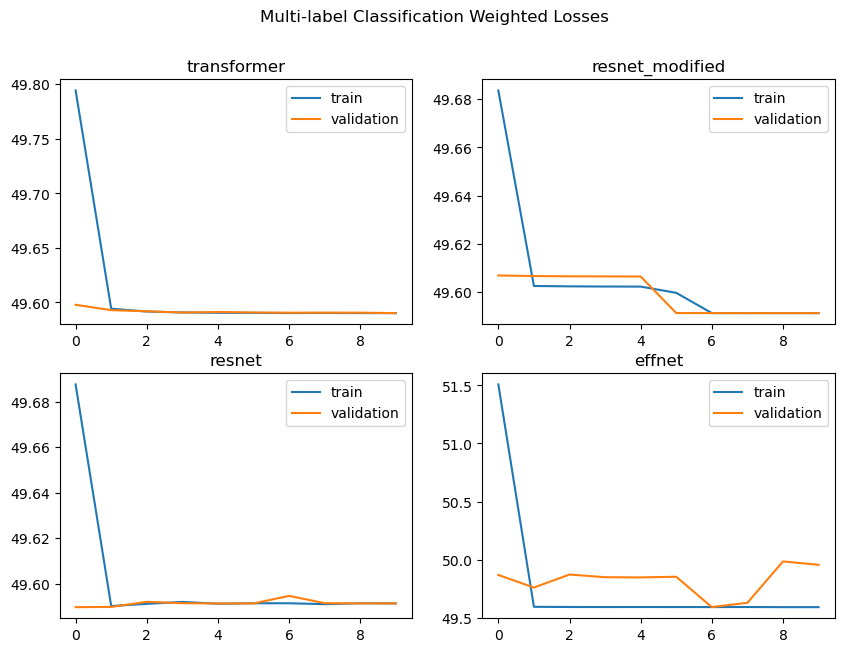

In [8]:
metrics = [met for met in os.listdir('multi_label_output/weights') if met[-11:]=='metrics.csv']

fig, axis = plt.subplots(2, 2, figsize=(10, 7))

for metric_file_name, ax in zip(metrics, axis.flatten()):
    
    path_metric = os.path.join('multi_label_output/weights', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    ax.plot(np.arange(len(train_loss)), train_loss, label='train')
    ax.plot(np.arange(len(val_loss)), val_loss, label='validation')
    ax.legend(loc="upper right")
    ax.set_title(metric_file_name[:-12])
    
plt.suptitle('Multi-label Classification Weighted Losses')
plt.savefig('labweights.png')

plt.show()

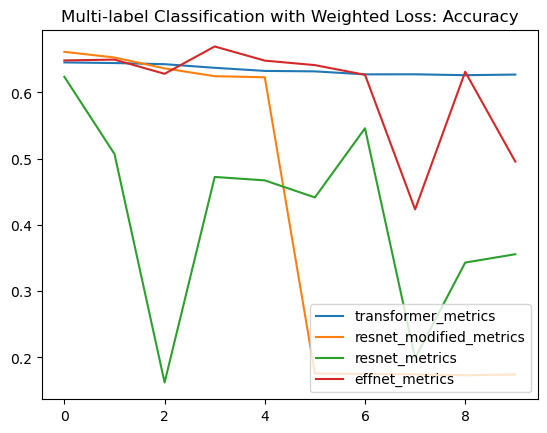

In [130]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_label_output/weights', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-4])
    plt.legend(loc='lower right')
    plt.title('Multi-label Classification with Weighted Loss: Accuracy')
    
plt.savefig('labweightsacc.png')

In [143]:
TRESHOLD=0.001


pred_metrics = [met for met in os.listdir('multi_label_output/weights') if met[:4]=='pred']
true_metrics = [met for met in os.listdir('multi_label_output/weights') if met[:4]=='true']


metrics = []
models_name = [item.split('.')[0][5:] for item in sorted(true_metrics)]

for true, pred in zip(sorted(true_metrics), sorted(pred_metrics)):
    true = pd.read_csv('multi_label_output/weights/'+ true).astype(int).values
    pred = pd.read_csv('multi_label_output/weights/'+ pred)
    pred = (pred > TRESHOLD).astype(int).values
    
    metrics.append((true, pred))
    
    
eval_metrics(metrics, models_name, multi_label=True)

,model,Exact Match Ratio,Hamming loss,Recall,Precision,F1
0,effnet,0.008029,0.008029,0.008475,0.008921,0.008623
1,resnet,0.380018,0.380018,0.380018,0.380018,0.380018
2,resnet_modified,0.520963,0.520963,0.520963,0.520963,0.520963
3,transformer,0.520963,0.520963,0.520963,0.520963,0.520963
